In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

tf.set_random_seed(777)

1.9.0


In [2]:
learning_rate = 0.0002
training_epochs = 300
batch_size = 100
noise_dim = 128

In [3]:
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()

In [6]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [7]:
train_init = iterator.make_initializer(train_dataset)

In [8]:
vec_images = tf.reshape(images, [-1, 28*28])
vec_images = tf.cast(vec_images, tf.float32) / 255.
onehot_labels = tf.one_hot(labels, 10)

In [9]:
Z = tf.placeholder(tf.float32, [None, noise_dim])

In [10]:
def generator(noise):
    with tf.variable_scope('generator') as scope:
        gen1 = tf.layers.dense(inputs=noise,
                               units=256,
                               activation=tf.nn.relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen1)
       
        gen2 = tf.layers.dense(inputs=gen1,
                               units=28*28,
                               activation=tf.nn.sigmoid,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen2)        
        return gen2

In [11]:
def discriminator(image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        dis1 = tf.layers.dense(inputs=image,
                               units=256,
                               activation=tf.nn.relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis1)
        
        dis2 = tf.layers.dense(inputs=dis1,
                               units=1,                           
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis2)
        return dis2

In [12]:
def get_noise(batch_size, noise_dim):
    return np.random.uniform(-1., 1., size=[batch_size, noise_dim])

In [13]:
G = generator(Z)

Tensor("generator/dense/Relu:0", shape=(?, 256), dtype=float32)
Tensor("generator/dense_1/Sigmoid:0", shape=(?, 784), dtype=float32)


In [14]:
D_real = discriminator(vec_images)

Tensor("discriminator/dense/Relu:0", shape=(?, 256), dtype=float32)
Tensor("discriminator/dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)


In [15]:
D_fake = discriminator(G, True)

Tensor("discriminator_1/dense/Relu:0", shape=(?, 256), dtype=float32)
Tensor("discriminator_1/dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)


In [16]:
loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_real, labels=tf.ones_like(D_real)))
loss_D_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_fake, labels=tf.zeros_like(D_fake)))

In [17]:
loss_D = loss_D_real + loss_D_fake

In [18]:
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_fake, labels=tf.ones_like(D_fake)))

In [19]:
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

In [20]:
train_D = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_G, var_list=vars_G)

In [21]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

Training Start


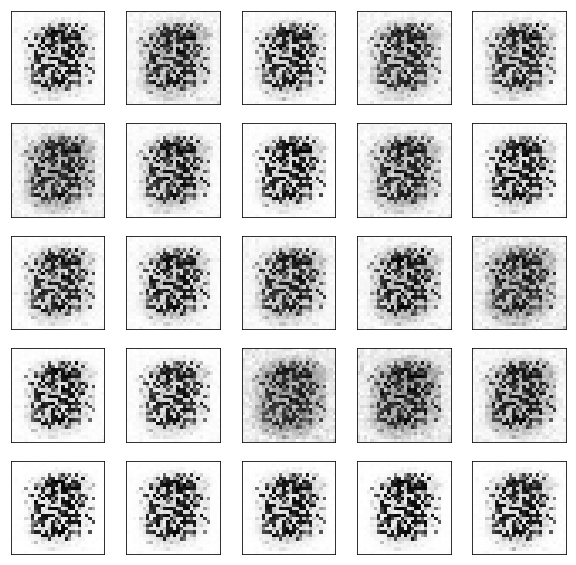

KeyboardInterrupt: 

In [22]:
print('Training Start')
for epoch in range(training_epochs):
    avg_loss_D = 0.
    avg_loss_G = 0.
    total_batch = int(train_images.shape[0] / batch_size)    
    
    sess.run(train_init)
    noise = get_noise(batch_size, noise_dim)
    
    for i in range(total_batch):
        _, l_D = sess.run([train_D, loss_D], feed_dict={Z: noise})
        _, l_G = sess.run([train_G, loss_G], feed_dict={Z: noise})
        avg_loss_D += l_D / total_batch
        avg_loss_G += l_G / total_batch
    
    if (epoch+1) % 10 == 0:
        print('Epoch:', '{}'.format(epoch + 1),
              'loss_D =', '{:.8f}'.format(avg_loss_D),
              'loss_G =', '{:.8f}'.format(avg_loss_G))
    if epoch == 0 or (epoch+1) % 10 == 0:
        sample_size = 25
        noise = get_noise(sample_size, noise_dim)
        #print(noise)
        samples = sess.run(G, feed_dict={Z: noise})
        samples = np.reshape(samples, (-1, 28, 28))
        #print(samples)
        
        plt.figure(figsize=(10,10))
        for i in range(sample_size):
            plt.subplot(5,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(samples[i], cmap=plt.cm.binary)
        plt.show()